<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG - Iris Dataset
This notebook modifies the code in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) to work with the Iris Dataset. In addition, it explores whether it is possible to repeat the same procedure on the batch input gradient.

In [2]:
# setting up libraries and device
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
torch.manual_seed(100) # for generating the same random weights

# for testing
from random import randint
from random import shuffle
from itertools import permutations
from scipy.optimize import linear_sum_assignment

from sklearn.datasets import load_iris
dst = load_iris()

print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

1.12.1+cu113
Running on cuda


In [3]:
# auxiliary functions for NN - conver to onehot and loss function
def label_to_onehot(target, num_classes = 3):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [4]:
# a random fully connected neural network with random weights and biases
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(4, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 3),
            act(),
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        return out
    
net = FcNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [5]:
# process input flowers and compute gradient of batch
def batch_grad(flower_indices, verbose = 0):
    n = len(flower_indices)

    gt_dataset = []
    gt_labels = []
    for flower_index in flower_indices:
        gt_data = torch.tensor(dst.data[flower_index, :]).to(device)
        gt_data = gt_data.view(1, *gt_data.size())
        gt_dataset.append(gt_data)
        gt_label = torch.tensor(dst.target[flower_index]).to(device)
        gt_label = gt_label.view(1)
        gt_labels.append(gt_label)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

        # print out (data, label) and verify onehot
        if (verbose):
            print(f"gt_data: {gt_data}")
            print(f"gt_label: {gt_label}")
            print(f"gt_onehot_label: {gt_onehot_label}")
            print(f"flower {flower_index} has label (gt, onehot) = ({gt_label.item()}, {torch.argmax(gt_onehot_label, dim=-1).item()})")

        # compute original gradient 
        out = net(gt_data.float())
        y = criterion(out, gt_onehot_label)

        if (flower_index == flower_indices[0]):
          batch_dy_dx = torch.autograd.grad(y, net.parameters())
        else:
          batch_dy_dx = tuple(map(sum, zip(batch_dy_dx, torch.autograd.grad(y, net.parameters())))) # sum of gradients

    batch_dy_dx = tuple(part/n for part in batch_dy_dx)
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients

    # verifying dy_dx is average of list of flowers
    if (verbose >= 2):
      print(original_dy_dx)
    
    return original_dy_dx, gt_dataset, gt_labels

In [6]:
# DLG algorithm on a given set of flowers and returns the hypothesized input
def batch_DLG(original_dy_dx, n, gt_data_len, gt_onehot_label_len, verbose = 0):

    # identify (data, label) using Adam on the squared difference between the original and guessed gradient
    dummy_data = [torch.randn(gt_data_len).to(device).requires_grad_(True) for i in range(n)]
    dummy_label = [torch.randn(gt_onehot_label_len).to(device).requires_grad_(True) for i in range(n)]
    optimizer = torch.optim.LBFGS(dummy_data+dummy_label)

    global opt_steps; opt_steps = 0
    for iters in range(100):

        # closure function needed for LBFGS optimizer
        def closure():
            global opt_steps; opt_steps += 1

            # compute gradient of dummy data/label
            optimizer.zero_grad()
            for i in range(n):
                pred = net(dummy_data[i]) 
                #print(f"prediction: {pred} from data: {dummy_data.data} and label: {dummy_label}") # uncomment to see optimization updates
                dummy_onehot_label = F.softmax(dummy_label[i], dim=-1)
                dummy_loss = criterion(pred, dummy_onehot_label) if (i == 0) else dummy_loss + criterion(pred, dummy_onehot_label)
            
            dummy_loss /= n
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
            
            # compute loss function, i.e. the SE of the gradients
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()

            grad_diff.backward()
            return grad_diff
        
        # perform GD and log information
        optimizer.step(closure)
        current_loss = closure()
        if (verbose == 2):
            print('current loss: ', iters, "%.4f" % current_loss.item())
            print('dummy data: ', dummy_data)
            print('dummy labels: ', dummy_label)
        
        # if current_loss is small enough, then the model has 'converged'
        if (closure() < 1e-9):
            break
    
    return dummy_data, opt_steps

In [7]:
# find best linear sum assignment
def assign_guess(guess, gt_dataset, n, verbose = False):
    cost_matrix = [[torch.sum((guess[i]-gt_dataset[j])**2).item() for j in range(n)] for i in range(n)]
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    best_MSE = sum([cost_matrix[row_ind[i]][col_ind[i]] for i in range(n)]) / n
    if (verbose):
        print('best guessed-actual assignment: ', col_ind)
        print('best_MSE: ', best_MSE)

    guess_perm = [None] * n
    for i in range(n):
        guess_perm[col_ind[i]] = guess[i]

    return guess_perm

In [8]:
# testing Batch-DLG on n random flowers
def test_rand(n = 10, verbose = False):
    length = dst.data.shape[0]
    perm = list(range(length))
    shuffle(perm)
    flower_indices = perm[0:n]
    if (verbose):
        print('flowers: ', flower_indices)

    original_dy_dx, gt_dataset, gt_labels = batch_grad(flower_indices, 0)
    guess, steps = batch_DLG(original_dy_dx, n, gt_dataset[0].size(), label_to_onehot(gt_labels[0]).size(), 1)
    if (verbose):
        print(f"Original data: {gt_dataset}")
        print(f"Predicted data: {guess}")
        print('steps: ', steps)

    guess_perm = assign_guess(guess, gt_dataset, n, verbose)

    if (verbose):
        print('side by side comparison of guessed to actual input data: ')
    avg_cos_angle = 0
    best_MSE = 0
    for i in range(n):
        SE = torch.sum((guess_perm[i]-gt_dataset[i])**2).item()
        cos_angle = (torch.sum(guess_perm[i]*gt_dataset[i]).item() / (torch.linalg.norm(gt_dataset[i]) * torch.linalg.norm(guess_perm[i]))).item()
        avg_cos_angle += cos_angle
        best_MSE += SE
        if (verbose):
            print(i, ':', gt_dataset[i].tolist(), guess_perm[i].tolist())
            print('SE: ', SE, 'cos(angle): ', cos_angle)

    avg_cos_angle /= n
    best_MSE /= n
    if (verbose):
        print('average cos(angle): ', avg_cos_angle)
        print('MSE: ', best_MSE)
    
    return best_MSE, avg_cos_angle, steps

In [9]:
# testing batch-DLG on 20 groups of 10 flowers
test_len = 20
errors = []
cos_angles = []
optimization_steps = []
for i in range(test_len):
    MSE, avg_cos_angle, steps = test_rand(10, False)
    errors.append(MSE)
    optimization_steps.append(steps)
    cos_angles.append(avg_cos_angle)
    
print(errors)
print(optimization_steps)
print(cos_angles)

[8.118956361122565, 0.055858512514358485, 6.419605824844167, 0.11070858183751138, 0.07483974686036232, 2.444843289005946, 0.10220913592374452, 2.8786715826541283, 3.7247727050667754, 0.18239144748522945, 0.3293171977973592, 0.33117407877893457, 1.9148268971371287, 0.10923010197648772, 2.351732699408792, 6.0019114246422625, 18.732187235087462, 0.06480022724263595, 0.226464095273497, 0.13871180010869089]
[416, 420, 489, 459, 345, 453, 425, 467, 544, 451, 365, 446, 482, 469, 487, 476, 439, 549, 384, 413]
[0.8090576443634759, 0.9997779250556716, 0.9289891367681113, 0.9995169508056424, 0.9994088466873157, 0.9862589396699526, 0.9993894625656106, 0.9775509370703546, 0.9810899442154314, 0.9997598549036214, 0.999307028081228, 0.9992826268614861, 0.9784162784779553, 0.999404111623486, 0.9814950450977262, 0.9828777726766538, 0.8013076547845446, 0.9997154599807997, 0.9995282311710298, 0.9991619937501582]


*** change caption This graph was generated on the entire IRIS dataset consisting of 150 flowers.
It utilizes a randomly initialized fully connected NN as its prediction algorithm.


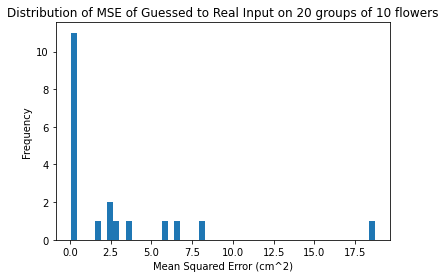

In [10]:
# visually represent errors in a histogram
plt.hist(errors, 50)
plt.title('Distribution of MSE of Guessed to Real Input on 20 groups of 10 flowers')
plt.ylabel('Frequency')
plt.xlabel('Mean Squared Error (cm^2)')
print('*** change caption This graph was generated on the entire IRIS dataset consisting of 150 flowers.\nIt utilizes a randomly initialized fully connected NN as its prediction algorithm.')
plt.savefig('batch-gradient-MSE.png', dpi=300)

Note that the number of optimization steps is measured in terms of the number of times the closure function is called in the LBFGS optimizer


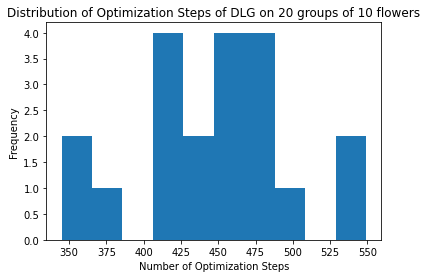

In [15]:
# visually represent number of optimization steps
plt.hist(optimization_steps, 10)
plt.title('Distribution of Optimization Steps of DLG on 20 groups of 10 flowers')
plt.xlabel('Number of Optimization Steps')
plt.ylabel('Frequency')
plt.savefig('batch-gradient-steps.png', dpi=300)
print('Note that the number of optimization steps is measured in terms of the number of times the closure function is called in the LBFGS optimizer')

Note that the number of optimization steps is measured in terms of the number of times the closure function is called in the LBFGS optimizer


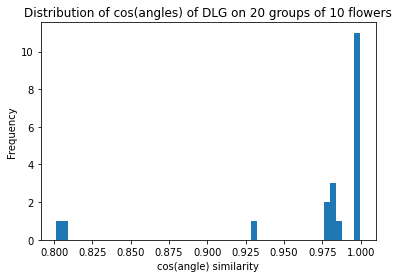

In [12]:
# visually represent avg_cos_angles
plt.hist(cos_angles, 50)
plt.title('Distribution of cos(angles) of DLG on 20 groups of 10 flowers')
plt.xlabel('cos(angle) similarity')
plt.ylabel('Frequency')
plt.savefig('batch-gradient-cangles.png', dpi=300)
print('Note that the number of optimization steps is measured in terms of the number of times the closure function is called in the LBFGS optimizer')

In [13]:
# Todo
# set an upper limit on the optimization steps
# create graphs of cos(theta) of guessed and actual input data (and SE)
# try to train a good model and then check if it makes a difference of attackability of input data
# what is the upper limit on the size of the batch?